In [1]:
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop AcademicYear column"""
    filtered_df = df[df["AcademicYear"] == year].copy()
    return filtered_df.drop(columns=["AcademicYear"])


def standarized_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}

    for col in acgr_df.columns:
        parts = col.split(".")
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col

    return renamed_df.rename(columns=new_columns)


census_to_acgr_mapping = {
    # Race/Ethnicity
    "RE_B": "RB",  # African American
    "RE_I": "RI",  # American Indian or Alaska Native
    "RE_A": "RA",  # Asian
    "RE_F": "RF",  # Filipino
    "RE_H": "RH",  # Hispanic or Latino
    "RE_D": "RD",  # Not Reported
    "RE_P": "RP",  # Pacific Islander
    "RE_T": "RT",  # Two or More Races
    "RE_W": "RW",  # White
    # Gender
    "GN_M": "GM",  # Male
    "GN_F": "GF",  # Female
    "GN_X": "GX",  # Non-Binary
    "GN_Z": "GZ",  # Missing Gender
    # Student Groups
    "SG_EL": "SE",  # English Learners
    "SG_DS": "SD",  # Students with Disabilities
    "SG_SD": "SS",  # Socioeconomically Disadvantaged
    "SG_MG": "SM",  # Migrant
    "SG_FS": "SF",  # Foster
    "SG_HM": "SH",  # Homeless
    # Total
    "TA": "TA",  # Total
}

In [3]:
from functools import reduce

# Get tables
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)
public_schools = pd.read_sql_query("SELECT * FROM PublicSchools", con)

pattern = "Virtual|Magnet|YearRound|Multilingual"
public_schools = public_schools.filter(regex=pattern)
census_day_standardized = standarized_columns(census_day, census_to_acgr_mapping)


def add_suffix_except(df, suffix, exclude=("SchoolCode", "AcademicYear")):
    return df.rename(
        columns={col: f"{col}{suffix}" for col in df.columns if col not in exclude}
    )


# Reduce columns
census_day_reduced = census_day.drop(
    columns=["AggregateLevel", "DistrictCode", "CountyCode"], errors="ignore"
)
acgr_reduced = acgr.drop(columns=["DistrictCode", "CountyCode"], errors="ignore")

# Merge DataFrames
dfs = [
    census_day_reduced,
    acgr_reduced,
]

merged = reduce(
    lambda left, right: pd.merge(left, right, on="SchoolCode", how="inner"), dfs
)
merged = filter_academic_year(merged, "2023-24")

columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
    or col.startswith("Other")
    or col.startswith("GR_")
    or col.startswith("GED")
    or col.startswith("SPED")
    or col.startswith("TOTAL")
]
merged


,SchoolCode,Charter,TOTAL_ENR.GN_F,GR_TK.GN_F,GR_KN.GN_F,GR_01.GN_F,GR_02.GN_F,GR_03.GN_F,GR_04.GN_F,GR_05.GN_F,...,Other.GZ,OtherRate.GZ,RegHSDiploma.GZ,RegHSDiplomaRate.GZ,SPED.GZ,SPEDRate.GZ,StillEnrolled.GZ,StillEnrolledRate.GZ,UniReqs.GZ,UniReqsPercent.GZ
0,131755,N,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,131755,N,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,131755,N,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
3,131755,N,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,131755,N,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10183,5838305,N,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
10184,5838305,N,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
10185,5838305,N,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
10186,5838305,N,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


### XGBoost


In [4]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
target_column = "RegHSDiplomaRate.TA"

cv_result = cross_validate_xgboost(
    df=merged,
    target_column=target_column,
    columns_to_drop=[target_column] + columns_to_drop,
    n_splits=5,
    print_results=True,
    n_jobs=-1,
)

Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2023-24:
RMSE: 8.0013 ± 0.7845
MAE: 4.3853 ± 0.1309
R^2: 0.5377 ± 0.0549


<Figure size 1400x600 with 0 Axes>

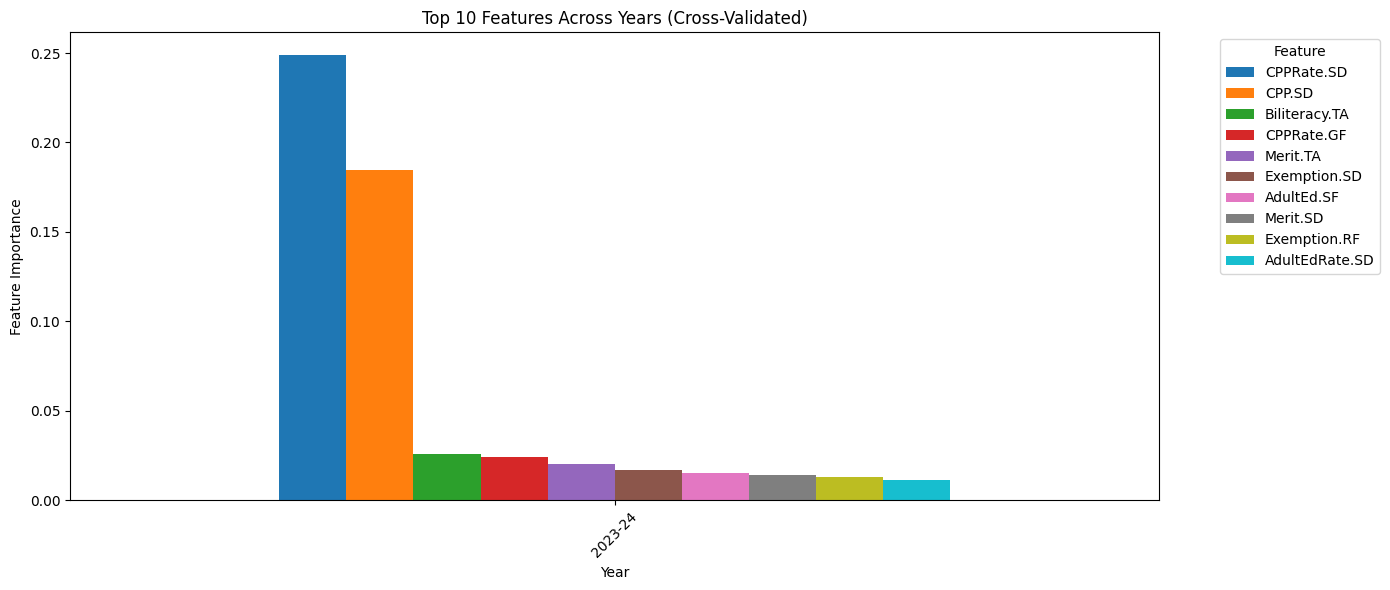

In [5]:
top_features = plot_cv_feature_importance({"2023-24": cv_result}, top_n=10)

In [6]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance

target_column = "UniReqsPercent.TA"

cv_result = cross_validate_xgboost(
    df=merged,
    target_column=target_column,
    columns_to_drop=[target_column] + columns_to_drop,
    n_splits=5,
    print_results=True,
    n_jobs=-1,
)

Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2023-24:
RMSE: 13.1039 ± 0.4615
MAE: 9.1466 ± 0.2765
R^2: 0.6568 ± 0.0199


<Figure size 1400x600 with 0 Axes>

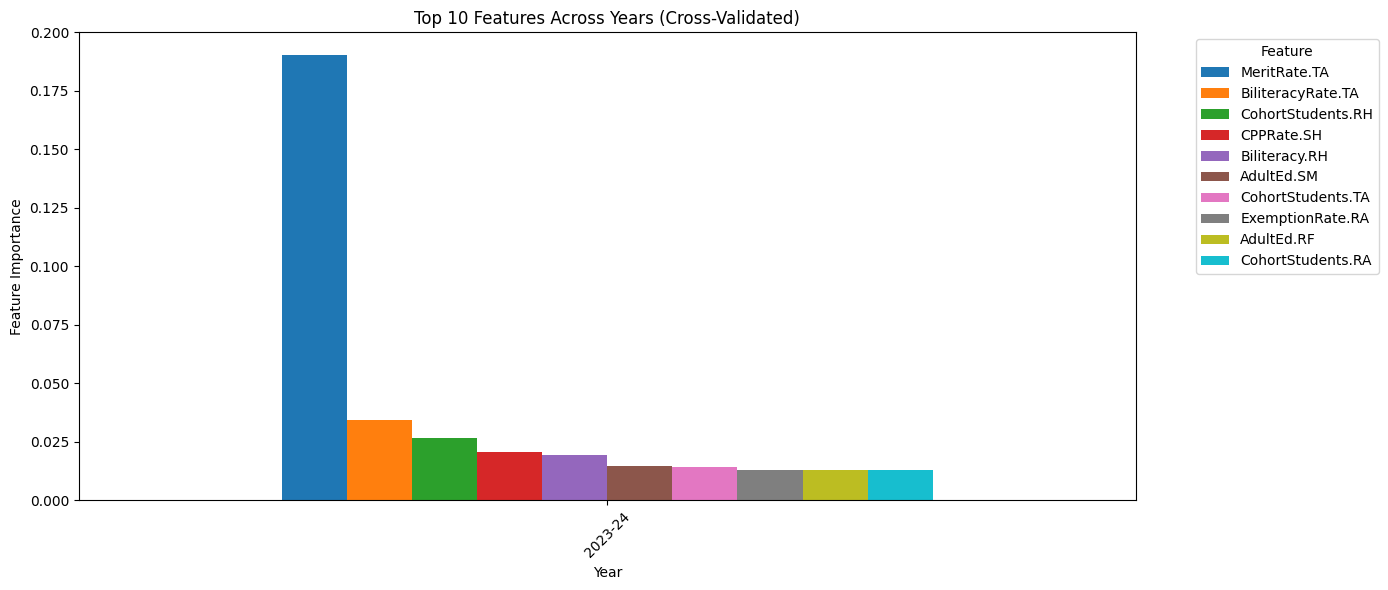

In [7]:
top_features = plot_cv_feature_importance({"2023-24": cv_result}, top_n=10)

### Random Forest

In [8]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
)

target_column = "RegHSDiplomaRate.TA"

cv_result = cross_validate_random_forest(
    df=merged,
    target_column=target_column,
    columns_to_drop=[target_column] + columns_to_drop,
    n_splits=5,
    print_results=True,
    n_jobs=-1,
)

Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2023-24:
RMSE: 8.1311 ± 0.8169
MAE: 4.4395 ± 0.1920
R²: 0.5298 ± 0.0544


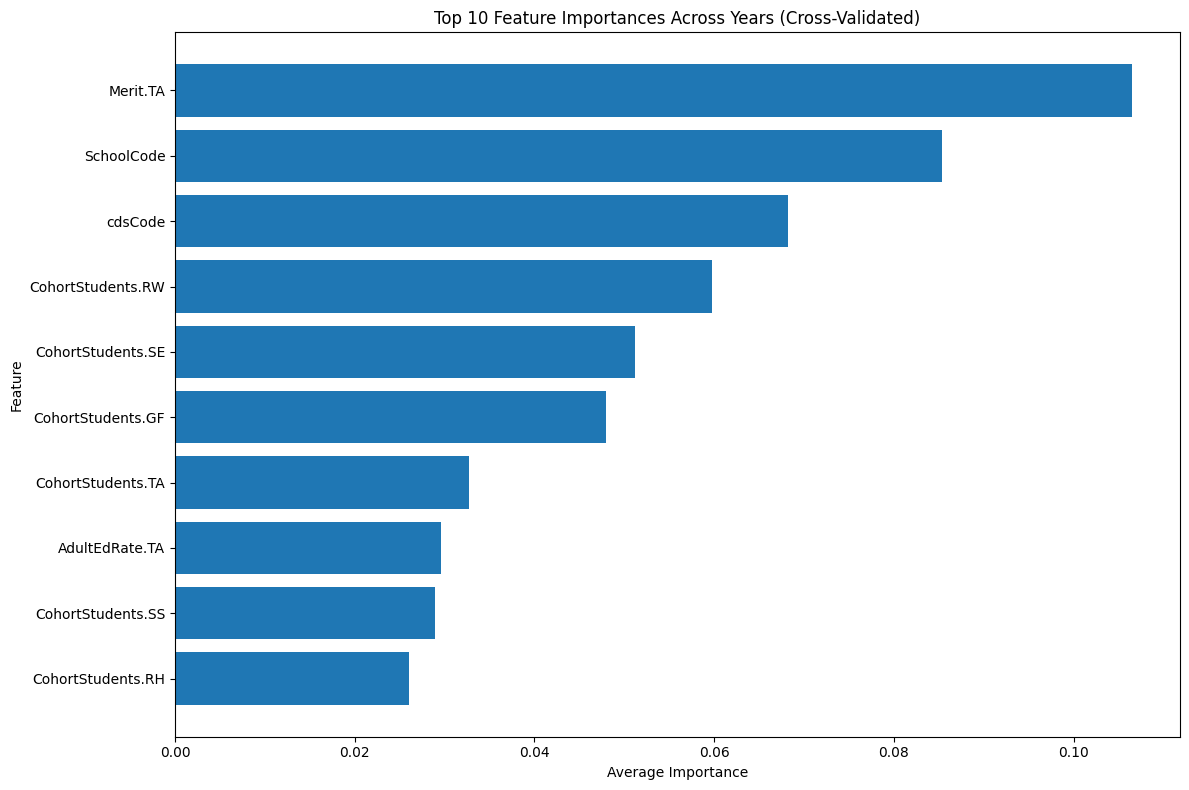

In [9]:
top_features = plot_cv_feature_importance_rf({"2023-24": cv_result}, top_n=10)

In [10]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
)

target_column = "UniReqsPercent.TA"

cv_result = cross_validate_random_forest(
    df=merged,
    target_column=target_column,
    columns_to_drop=[target_column] + columns_to_drop,
    n_splits=5,
    print_results=True,
    n_jobs=-1,
)

Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2023-24:
RMSE: 13.3150 ± 0.4663
MAE: 9.2063 ± 0.2684
R²: 0.6488 ± 0.0227


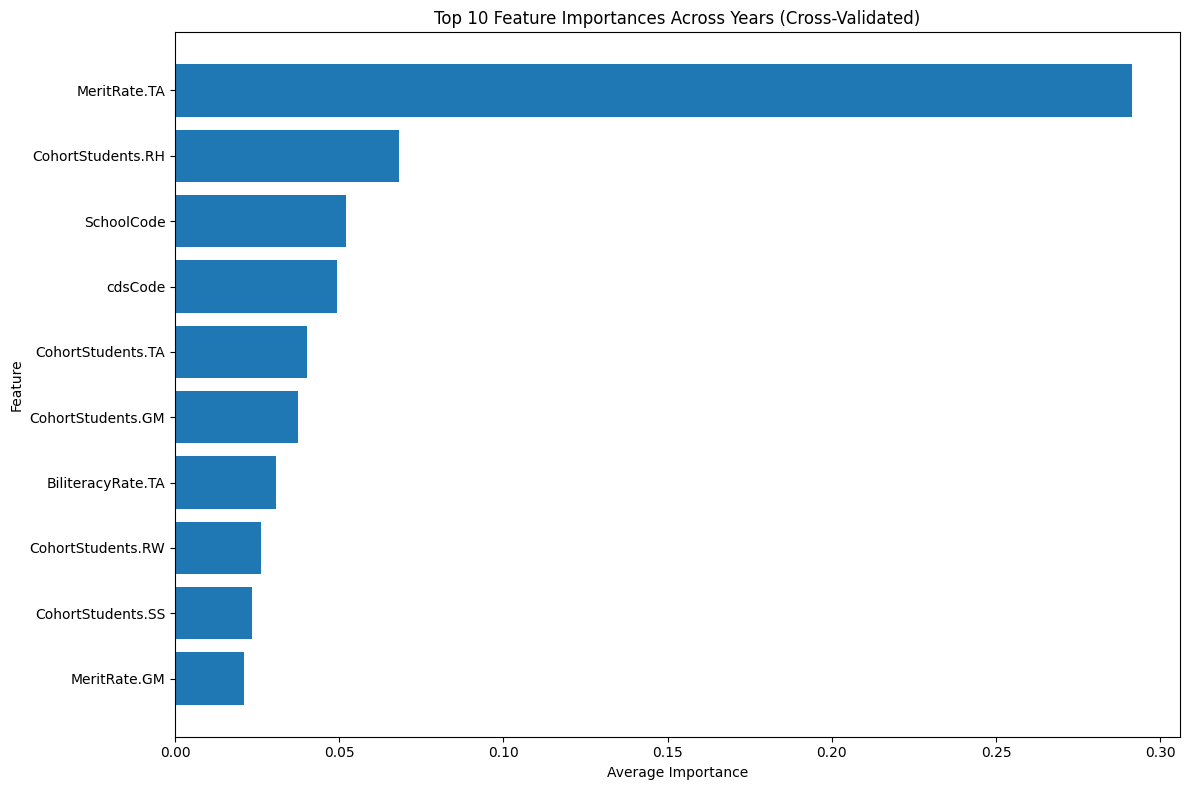

In [11]:
top_features = plot_cv_feature_importance_rf({"2023-24": cv_result}, top_n=10)